In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import tree 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Perform Decision Tree and GBT on Data With No Feature Engineering  
Assignment 2 was completed by calculating accuracy with minimal feature engineering. This section redoes the decision tree and gradient boosted tree to calculate the mean ROC AUC which is a better performance metric to compare. All the features are used with the minimal amount of feature engineering required for the classifiers to run on the data, applying the GIGO approach.  

In [3]:
#Read in all complete dataset, replace NaN values with 0 and drop object data types
#seperate the targets from the data and complete train/test split for the classifiers
loan = pd.read_csv('/content/drive/MyDrive/AAI510/MODULE1/home-credit-default-risk/application_train.csv')
loan = loan.replace(np.nan,0)
loan = loan.select_dtypes(exclude=['object'])

y = loan['TARGET']
x = loan.drop(columns=['TARGET']) 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [4]:
#Find mean ROC AUC for decision tree
clf = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy') 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print('The mean ROC AUC for the decision tree without feature engineering: %.3f' % metrics.roc_auc_score(y_train, pred_train))

The mean ROC AUC for the decision tree without feature engineering: 0.500


In [5]:
#Find mean ROC AUC for gradient boosted tree
gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=3, random_state=0)
gbc = gbc.fit(X_train, y_train)

pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)
print('The mean ROC AUC for the GBT without feature engineering: %.3f' % metrics.roc_auc_score(y_train, pred_train))

The mean ROC AUC for the GBT without feature engineering: 0.528


#2. Perform Feature Engineering on Original Data Set     

##2.1 Data Cleaning   
The first feature engineering technique used is data cleaning. "Incorrect or inconsistent data can lead to false conclusions. Therefore, it is imperative for data scientists to clean their data to ensure the results are accurate" (Lockhart, 2021, para. 4). This step is used to deal with missing data and inconsistent data types. Instead of replacing the missing data points with an arbitrary value, these points are dropped from the dataset. Instead of dropping the features with inconsistent data types, these are converted to a data type that can be handled by the classifiers.    

In [6]:
#Read in dataframe, drop Nan values, and treat objects as categorical features
df = pd.read_csv('/content/drive/MyDrive/AAI510/MODULE1/home-credit-default-risk/application_train.csv')
df = df.dropna()

for column in df:
  if df[column].dtypes == 'object':
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.codes

print('New shape of the dataset: ', df.shape)

New shape of the dataset:  (8602, 122)


##2.2 Feature Selection  
The second feature engineering technique used is feature selection. After completing the data cleaning, there are still 122 features in this dataset which can be too much. Instead, the choice is to select good data that is significant to the classifications being done instead of using a lot of data. This follows the discussion of whether more data or better data is better.  
  
To do this both classifiers are run with the cleaned dataset and the feature_importance function from sklearn is used to determine the most important features. It was chosen to do this step independently for both classifiers as they produced different results for the features and better overall performance metrics when done this way. 

In [7]:
#seperate the targets from the data and complete train/test split for the classifiers
y = df['TARGET']
x = df.drop(columns=['TARGET']) 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [8]:
#Rerun decision tree on the cleaned dataset to find features of most importance
clf = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy') 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

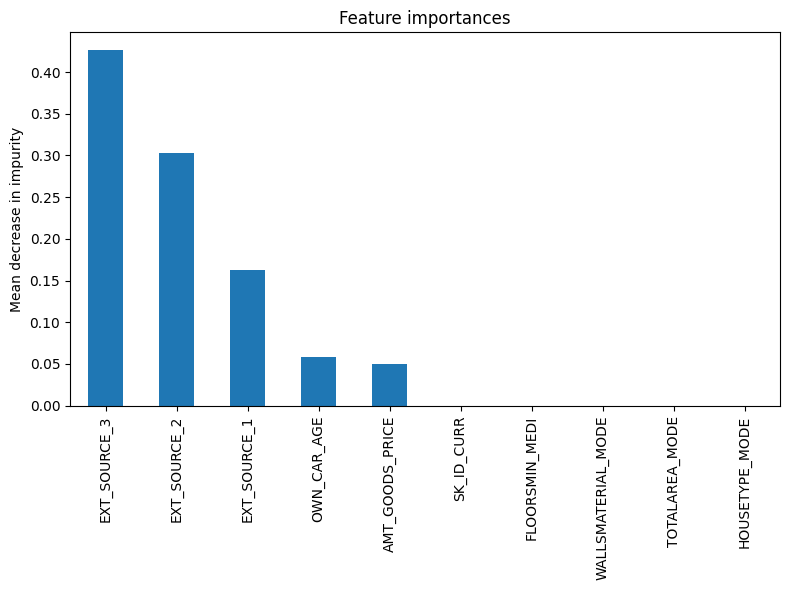

In [9]:
#Plot the variable importance chart and list the 10 features that are most important 
features = pd.Series(clf.feature_importances_, index=x.columns)
features.sort_values(ascending=False, inplace=True)
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(8,6))
features.head(10).plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
print('\n') #pdf printing purposes
print('\n')
print('\n')
print('\n')
print('\n')
print('\n')
print('\n')

As seen from the graph, only 5 features carry importance for the decision tree. The first 3 features alone are able to decrease the impurity by over 85%. When tested using the top three features resulted in the best performance metrics. 

In [10]:
#Rerun GBC on the cleaned dataset to find features of most importance
gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=3, random_state=0)
gbc = gbc.fit(X_train, y_train)

pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

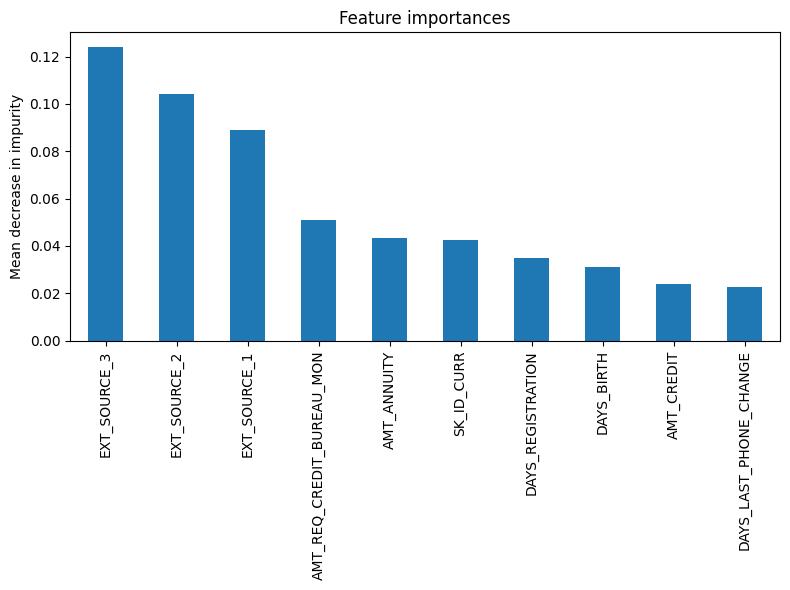

In [11]:
#Plot the variable importance chart and list the 10 features that are most important 
features = pd.Series(gbc.feature_importances_, index=x.columns)
features.sort_values(ascending=False, inplace=True)
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(8,6))
features.head(10).plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
print('\n') #pdf printing purposes
print('\n')
print('\n')
print('\n')
print('\n')
print('\n')
print('\n')
print('\n')

From the graph it can be seen that the individual features do not significantly reduce the impurity. When tested using the first 7 features of most importance resulted in the highest performance metric. 

##2.3 Sampling and Final Performance  
Performing two feature cleaning techniques and feature selection was able to significantly improve the performance metric for the gradient boosting classifier; however, the decision tree classifier was not improved at all. SMOTE sampling technique was used on the decision tree classifier, allowing for the minority class in the imbalanced dataset to be oversampled. This improved the results but not by a significant amount. 

In [12]:
#Read in dataset with the features of most importance for the decision tree
df1 = df[['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']]

In [13]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [15]:
#Perform SMOTE and calculate the new mean ROC AUC values for the decision tree 
y = df1['TARGET']
x = df1.drop(columns=['TARGET']) 

steps = [('over', SMOTE(sampling_strategy=0.07, k_neighbors=2)), 
          ('under', RandomUnderSampler(sampling_strategy=0.5)),
          ('model', tree.DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('The mean ROC AUC for the decision tree with feature engineering: %.3f' % mean(scores))

The mean ROC AUC for the decision tree with feature engineering: 0.580


In [16]:
#Read in dataset with the features of most importance for the GBT
df2 = df[['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'AMT_REQ_CREDIT_BUREAU_MON', 
         'AMT_ANNUITY', 'SK_ID_CURR', 'DAYS_REGISTRATION']]

In [17]:
#Calculate the new mean ROC AUC values for the GBT 
y = df2['TARGET']
x = df2.drop(columns=['TARGET']) 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=3, random_state=0)
gbc = gbc.fit(X_train, y_train)

pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)
print('The mean ROC AUC for the GBT with feature engineering: %.3f' % metrics.roc_auc_score(y_train, pred_train))

The mean ROC AUC for the GBT with feature engineering: 0.846


#3. Results   
From the results it can be seen that the gradient boosting classifier is more influenced by the feature engineering performed and its performance increases with less feature engineering. On the other hand, the decision tree classifier requires more feature engineering and had a smaller, almost non-significant, improvement in performance. To get better results with the decision tree classifier further data cleaning can be done such as replacing the missing values with the mode instead of being dropped. 

#References  
Lockhart, B. (2021, March 16). DataPrep.Clean: Accelerate Your Data Cleaning. *Towards Data Science.* https://towardsdatascience.com/dataprep-clean-accelerate-your-data-cleaning-83406b4645bf